**Übung Mustererkennung** *WS 2022/23* -- *K. Brandenbusch,  Gernot A. Fink* -- *Technische Universität Dortmund, Lehrstuhl XII, Mustererkennung in eingebetteten Systemen*
___
# Aufgabe 3: Vektorquantisierung zur Initialisierung eines Verteilungsmodells

Statt einer Normalverteilung pro Klasse bietet es sich häufig an, mehrere Verteilungen vorzusehen. Dafür ist es notwendig, geeignete Verteilungen im Datenraum zu ermitteln.
Für eine Initialisierung dieser Verteilungen bietet es sich an, die Daten zu Clustern. Anschließend kann für jedes Cluster eine Verteilung geschätzt werden.

In dieser Aufgabe sollen Sie den Algorithmus von Lloyd zur Vektorquantieisrung implementieren. Optional können Sie zusätzlich auf den $k$-means-Algorithmus nach McQueen implementieren.
***

Zuerst müssen die benötigten Module importiert werden.

In [49]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import sys
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import cdist

# Uebergeordneten Ordner zum Pfad hinzufuegen, damit das common Package importiert werden kann
if '..' not in sys.path:
    sys.path.append('..')

from common import visualization
from common.data_provider import DataProvider

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
## Visualisierung der Trainingsdaten

Laden Sie die Trainingsdaten (ohne Label) und visualisieren Sie die Trainingsdaten in einem Scatter-Plot. Plotten Sie zunächst alle Punkte farblos (`c='w', edgecolor='k'`).

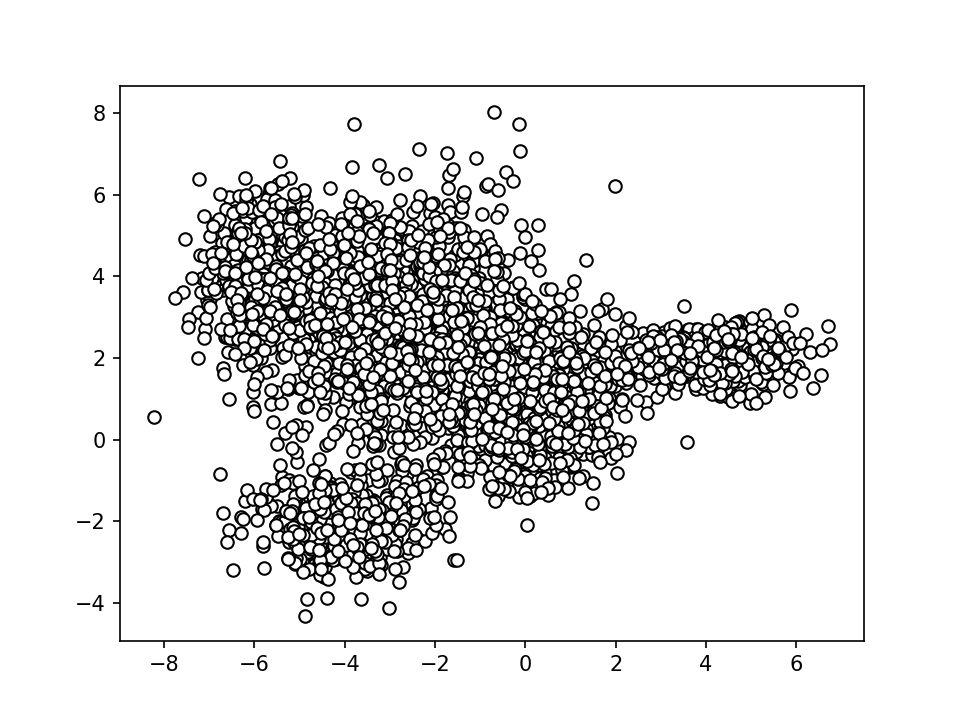

In [50]:
from common.data_provider import DataProvider
import matplotlib.pyplot as plt

train_data_provider = DataProvider(DataProvider.DATA2DROOT_TRAIN)
test_data_provider = DataProvider(DataProvider.DATA2DROOT_TEST)

_, ax = plt.subplots(dpi=150)

data = train_data_provider.get_class_arr(0)
ax.scatter(data[:, 0], data[:, 1], c='w', edgecolor='k')
data = train_data_provider.get_class_arr(1)
ax.scatter(data[:, 0], data[:, 1], c='w', edgecolor='k')
data = train_data_provider.get_class_arr(2)
ax.scatter(data[:, 0], data[:, 1], c='w', edgecolor='k')

---
## Initialisierung des Kodebuchs

Wählen Sie eine geeignete Kodebuchgröße und initialisieren Sie entsprechend viele zufällige Kodewörter.<br>
Hierzu können Sie die Methode [np.random.permutation](http://docs.scipy.org/doc/numpy/reference/generated/numpy.random.permutation.html) verwenden.

Visualisieren Sie anschließend die Kodewörter im zuvor erstellen Plot, indem Sie auf derselben axis erneut `scatter` aufrufen (der vorherige Plot wird dadurch aktualisiert).<br>
Geben Sie jedem Kodewort eine andere Farbe. Hierzu bietet sich die Verwendung einer [Colormap](https://matplotlib.org/stable/tutorials/colors/colormaps.html) an (z.B. `nipy_spectral` oder `gist_ncar`).

Warum ist es sinnvoll als Initialisierung zufällige Beispiele aus dem Datensatz auszuwählen?

In [51]:
import numpy as np 

k = 3

train_samples, train_labels = train_data_provider.get_dataset_and_labels()

resampled_train_data = np.random.permutation(train_samples)
codewords = resampled_train_data[:k]

colorOfCodeWords = ['r','g','b']
print(codewords)
ax.scatter(codewords[:, 0], codewords[:, 1], cmap="plasma", edgecolor='k')



[[ 4.6452769   2.31350517]
 [-2.56586455  5.11304551]
 [-0.86223702  0.90974183]]


C:\Users\marce\AppData\Local\Temp\ipykernel_2552\2767085682.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(codewords[:, 0], codewords[:, 1], cmap="plasma", edgecolor='k')


---
## Zuordnung der Beispiele zu Kodewörtern

Ordnen Sie alle Beispiele einem Kodewort nach der **Nächster-Nachbar-Regel** zu und visualisieren Sie farblich die Zuordnung.

Nützliche Funktionen: 
- [scipy.distance.cdist](http://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)
- [np.argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html)

[[4.97474279 3.38508166 1.7535546 ]
 [5.52848678 4.53444581 0.15714938]
 [3.96998932 5.18902286 1.7221539 ]
 ...
 [8.19128067 3.37792153 2.84178246]
 [8.88404387 1.55331026 4.72225329]
 [8.63732143 3.07481077 3.46140287]]
(4002, 3)


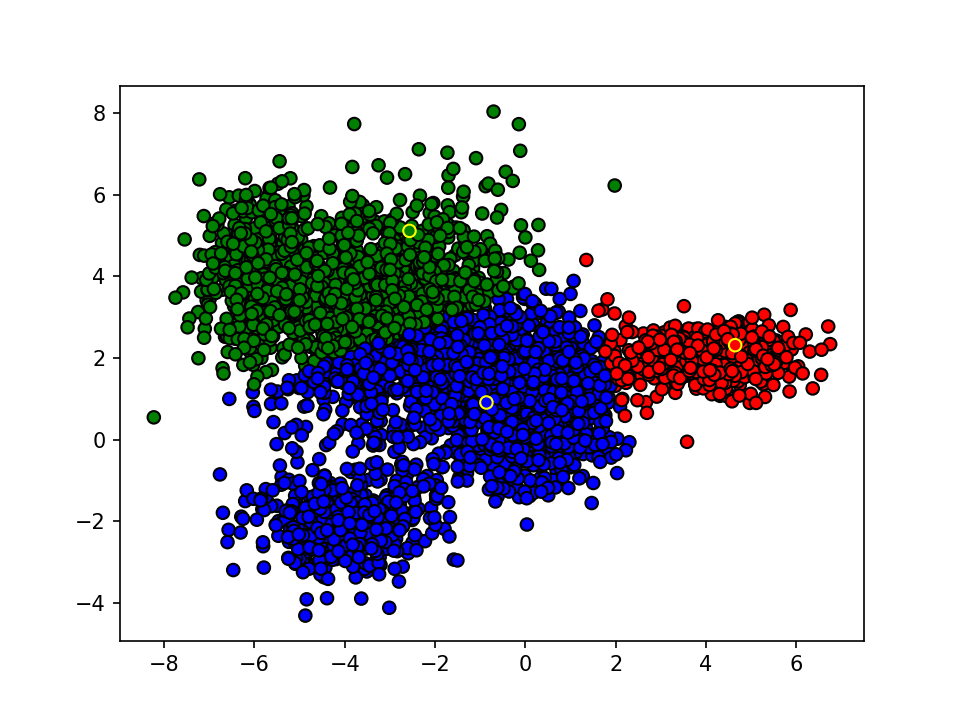

In [52]:
import scipy 
distancesBetweenTrainAndTest = scipy.spatial.distance.cdist(train_samples, codewords, metric='euclidean')
print(distancesBetweenTrainAndTest)
print(distancesBetweenTrainAndTest.shape)

colorOfTrainData = np.zeros(distancesBetweenTrainAndTest.shape[0], dtype=str)
closestClusterDistance = np.zeros(distancesBetweenTrainAndTest.shape[0])

for i in range(distancesBetweenTrainAndTest.shape[0]):
    closestCluster = distancesBetweenTrainAndTest[i].argmin()
    closestClusterDistance[i] = distancesBetweenTrainAndTest[i].min()
    colorOfTrainData[i] = colorOfCodeWords[closestCluster]

_, ax = plt.subplots(dpi=150)

ax.scatter(train_samples[:, 0], train_samples[:, 1], c=colorOfTrainData, edgecolor='k')
ax.scatter(codewords[:, 0], codewords[:, 1], c=['r','g','b'], edgecolor='yellow')

---
## Berechnung des Quantisierungsfehlers

Berechnen Sie den Fehler der Zuordnung:

$\large \varepsilon = \sum^{L}_{\rho=1}\int_{V_\rho}|\underline{f}-\underline{b}_\rho|^2 p(\underline{f})d\underline{f} $

$\large L $ ist hier die Größe des Kodebuchs und $\large \underline{b}_\rho $ die Kodewörter.<br>
Überlegen Sie, wie Sie den Fehler basierend auf der Stichprobe berechnen können:
- Was sind die Vektoren $\large \underline{f} $ der Volumina $\large {V_\rho} $?
- Wie kann $\large p(\underline{f}) $ basierend auf der Stichprobe geschätzt werden?

Nützliche Funktionen:
- [np.min](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.min.html)
- [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)

In [53]:
errors_over_iterations = []
error = np.mean(closestClusterDistance)
errors_over_iterations.append(error)
print(error)

2.2101433325565107


---
## Aktualisierung der Kodewörter

Berechnen Sie das optimale Kodebuch für die aktuelle Zuordnung der Punkte.

Nützliche Funktion:
- [np.mean](https://numpy.org/doc/stable/reference/generated/numpy.mean.html)

[[ 4.6452769   2.31350517]
 [-2.56586455  5.11304551]
 [-0.86223702  0.90974183]]
____________________
[[ 3.88238024  2.00100099]
 [-4.14289423  3.88743465]
 [-1.38262338  0.51031095]]


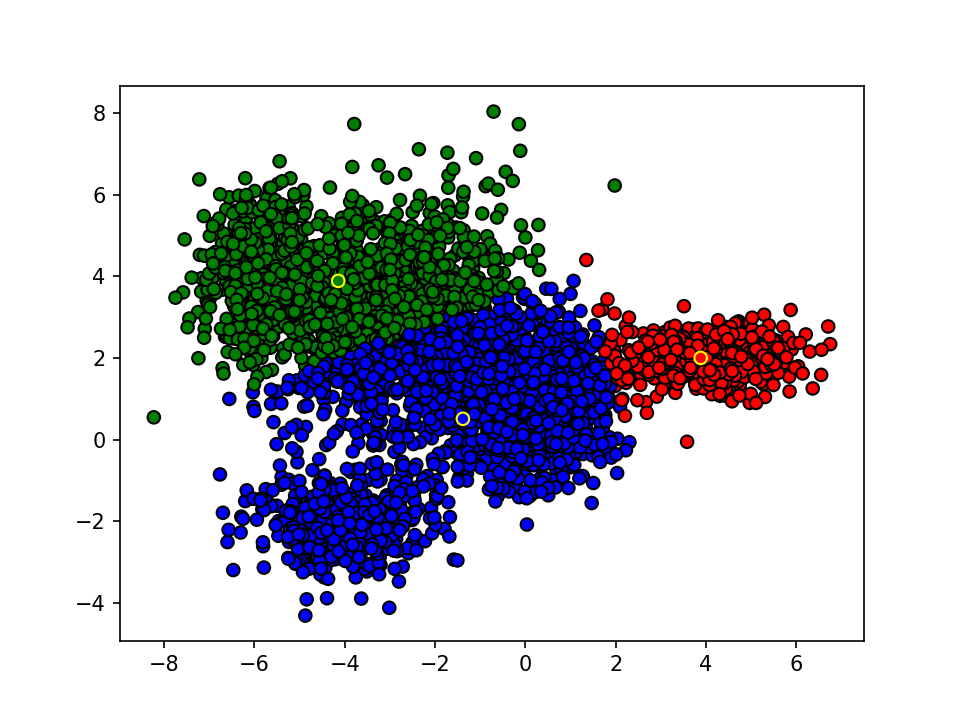

In [54]:
print(codewords)
print("____________________")
for i in range(len(codewords)):
    newCordWord = np.zeros(2, dtype=float)

    newCordWord[0] = np.mean(train_samples[colorOfTrainData==colorOfCodeWords[i]][:,0])
    newCordWord[1] = np.mean(train_samples[colorOfTrainData==colorOfCodeWords[i]][:,1])
    
    codewords[i] = newCordWord

print(codewords)

_, ax = plt.subplots(dpi=150)

ax.scatter(train_samples[:, 0], train_samples[:, 1], c=colorOfTrainData, edgecolor='k')
ax.scatter(codewords[:, 0], codewords[:, 1], c=['r','g','b'], edgecolor='yellow')

---
## Iterative Optimierung

Legen Sie einen Threshold für die relative Änderung des Fehlers fest. Wiederholen Sie die bisherigen Schritte, um so nach dem Algorithmus von Lloyd den Quantisierungsfehler zu minimieren, bis der festgelegte Threshold unterschritten wird.<br>
Geben Sie nach jeder Iteration den Quantisierungsfehler aus.

Warum ist es sinnvoll die relative Änderung des Quantisierungsfehler als Abbruchkriterium zu verwenden?

New Error: 1.9275025216061823 | relative Error 0.28264081095032845
New Error: 1.9169330596982443 | relative Error 0.01056946190793795
New Error: 1.9239571260376165 | relative Error 0.007024066339372137
New Error: 1.9295654424361033 | relative Error 0.005608316398486801
New Error: 1.9373065809789543 | relative Error 0.007741138542850967
New Error: 1.9436187455021159 | relative Error 0.006312164523161634
New Error: 1.9492771231599701 | relative Error 0.005658377657854263
New Error: 1.9527494690556482 | relative Error 0.0034723458956780195
New Error: 1.9551425662369872 | relative Error 0.0023930971813390656
New Error: 1.9557078292240728 | relative Error 0.0005652629870855908
New Error: 1.9548095224516318 | relative Error 0.0008983067724410709
New Error: 1.9513158552679433 | relative Error 0.003493667183688487
New Error: 1.9437614350627581 | relative Error 0.007554420205185153
New Error: 1.9320663392565123 | relative Error 0.011695095806245837
New Error: 1.918828052979222 | relative Error 

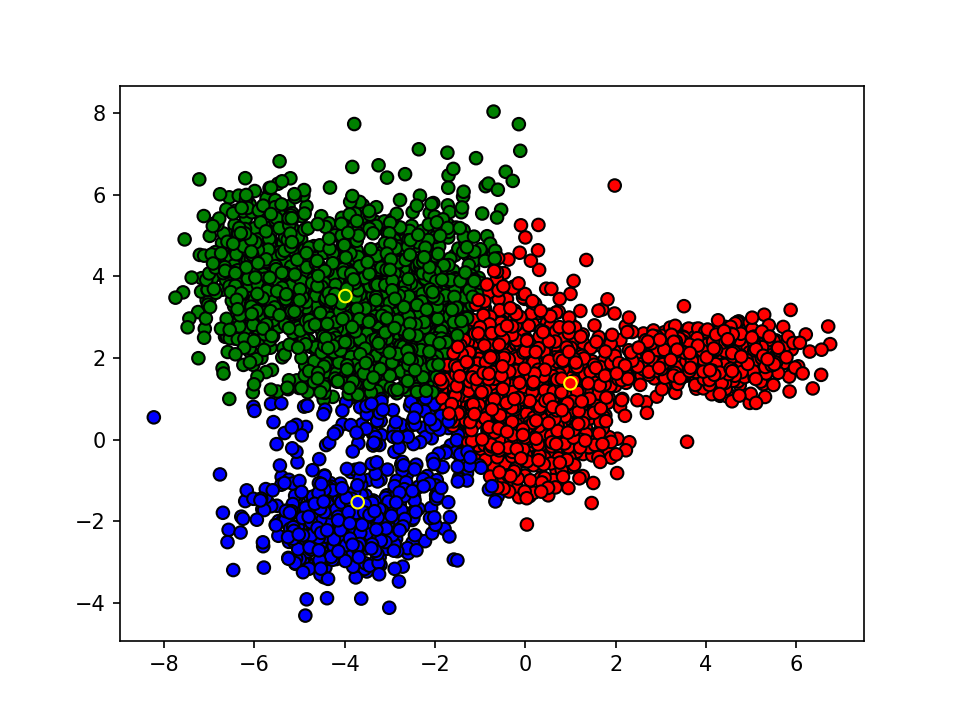

In [55]:
relativeError = 1000
threshhold_for_relative_error = 0.000001

while (relativeError > threshhold_for_relative_error):
    #distanzen und neuzuweisung der trainingsdaten zu cluster
    distancesBetweenTrainAndTest = scipy.spatial.distance.cdist(train_samples, codewords, metric='euclidean')

    colorOfTrainData = np.zeros(distancesBetweenTrainAndTest.shape[0], dtype=str)
    closestClusterDistance = np.zeros(distancesBetweenTrainAndTest.shape[0])

    for i in range(distancesBetweenTrainAndTest.shape[0]):
        closestCluster = distancesBetweenTrainAndTest[i].argmin()
        closestClusterDistance[i] = distancesBetweenTrainAndTest[i].min()
        colorOfTrainData[i] = colorOfCodeWords[closestCluster]

    #quantisierungsfehler 
    error = np.mean(closestClusterDistance)
    errors_over_iterations.append(error)

    #neu center of centroiden
    for i in range(len(codewords)):
        newCordWord = np.zeros(2, dtype=float)

        newCordWord[0] = np.mean(train_samples[colorOfTrainData==colorOfCodeWords[i]][:,0])
        newCordWord[1] = np.mean(train_samples[colorOfTrainData==colorOfCodeWords[i]][:,1])
        
        codewords[i] = newCordWord

    relativeError = np.abs(errors_over_iterations[-2] - error)
    print(f"New Error: {error} | relative Error {relativeError}")


#plotten
_, ax = plt.subplots(dpi=150)

ax.scatter(train_samples[:, 0], train_samples[:, 1], c=colorOfTrainData, edgecolor='k')
ax.scatter(codewords[:, 0], codewords[:, 1], c=['r','g','b'], edgecolor='yellow')

Visualisieren Sie das berechnete Kodebuch und die Zuordnung der Daten in einem neuen Plot.

---
## Implementierung des vollständigen Algorithmus

Implementieren Sie nun die Methode `Lloyd.cluster()` in dem Modul [`common.vector_quantization`](../common/vector_quantization.py). Hierzu können Sie größtenteils Ihren bisherigen Code verwenden.<br>
Die Methode soll als Eingabe die Beispieldaten erhalten, welche Zeilenweise vorliegen. Zudem wird die Größe des Kodebuchs übergeben.<br>
Wenn das Flag  `verbose=True` gesetzt ist, soll jede Iteration der Quantisierungsfehler in der Konsole augegeben werden.

**Optional**: Die Methode `Lloyd.cluster()` akzeptiert zudem das Flag `prune_codebook`. Wenn dies gesetzt wurde, sollen alle Kodewörter verworfen werden, welchen nicht mehr Beispiele der Trainingsdaten zugeordnet werden, als die Daten Dimensionen besitzen.<br>
Implementieren Sie die Funktionalität dises Flags.


Warum kann diese Funktionalität für die später geplante Verwendung nützlich sein?

---

Importieren Sie die Klasse Lloyd und clustern Sie die Trainingsdaten. Visualisieren Sie anschliend das Ergebnis und vergleichen Sie es mit dem zuvor berechneten Ergebnis.

Warum können die Ergebnisse trotz korrekter Implementierung unterschiedlich sein?

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

New Error: 1.9698497246533717 | relative Error 998.0301502753466
New Error: 1.8420563403412018 | relative Error 0.1277933843121699
New Error: 1.8038689159839982 | relative Error 0.03818742435720357
New Error: 1.741916725869398 | relative Error 0.06195219011460029
New Error: 1.6930841752111485 | relative Error 0.04883255065824943
New Error: 1.6579339693122777 | relative Error 0.03515020589887086
New Error: 1.6278293454394048 | relative Error 0.030104623872872827
New Error: 1.6130441510525324 | relative Error 0.014785194386872424
New Error: 1.6056938996850305 | relative Error 0.007350251367501892
New Error: 1.6028393189563606 | relative Error 0.002854580728669953


(array([[-4.98920487,  3.7788827 ],
        [ 1.97109928,  1.28546202],
        [-3.81304592, -1.72825175],
        [-1.53756255,  2.20789477]]),
 array([3, 3, 1, ..., 3, 0, 0]))

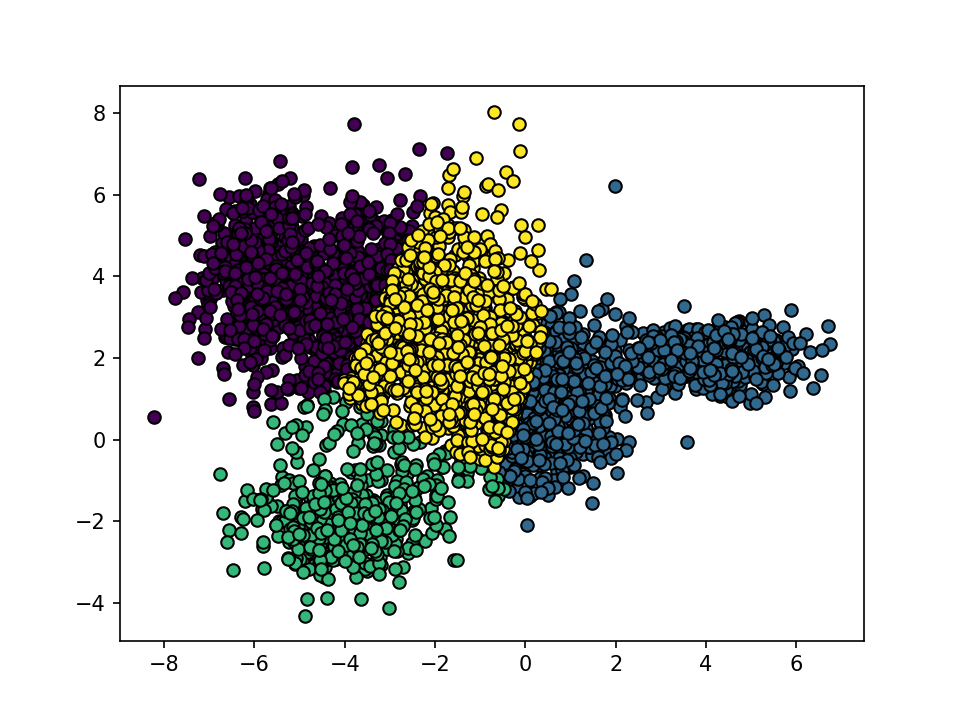

In [57]:
from common.vector_quantization import Lloyd

codeWordsSize = 4

iloydi = Lloyd()
iloydi.cluster(train_samples, codeWordsSize, False, True)